In [161]:
import pandas as pd 
import numpy as np 
import matplotlib.pylab as plt
import marshal
import pickle
import datetime as dt
from scipy.interpolate import interp1d
import matplotlib.cm as cm

# %matplotlib notebook 
%matplotlib inline 
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 15, 6


In [162]:
import os
elm_keys = dict()
path ='../datastore/paystations/'
for i in os.listdir(path):
    if i.endswith(".d") or i.endswith(".py"): 
        key = i.split('_')[0]
        elm_keys[key] = pickle.load(open(path + i, 'rb'))
        print 'paystation %s loaded' % key

paystation 17066 loaded
paystation 32489 loaded
paystation 32489 loaded
paystation 32489 loaded
paystation 32489 loaded
paystation 8005 loaded


In [163]:
clr = np.linspace(0, 1, len(elm_keys.keys()))

def plot_paystation(data, key, i):
    y = data.flatten()
    x = np.linspace(1, len(y), num=len(y))
    plt.plot(x, y, color=cm.cool(clr[i]))
    plt.ylabel('Parked cars')
    plt.xlabel('Hour')
    plt.title('Density for paystation %s' % key)
    plt.show()
    
def plot_paystation_interp(data, key, i):
    y = data.flatten()
    x = np.linspace(1, len(y), num=len(y))
    f = interp1d(x, y, kind='cubic')
    x_s = np.linspace(0, len(y), num=len(y), endpoint=True)
    plt.plot(x, y, 'o', color=cm.cool(clr[i]))
    plt.plot(x_s, f(x_s), color=cm.cool(clr[i+1]))
    plt.ylabel('Parked cars')
    plt.xlabel('Hour')
    plt.title('Density for paystation %s' % key)
    plt.show()


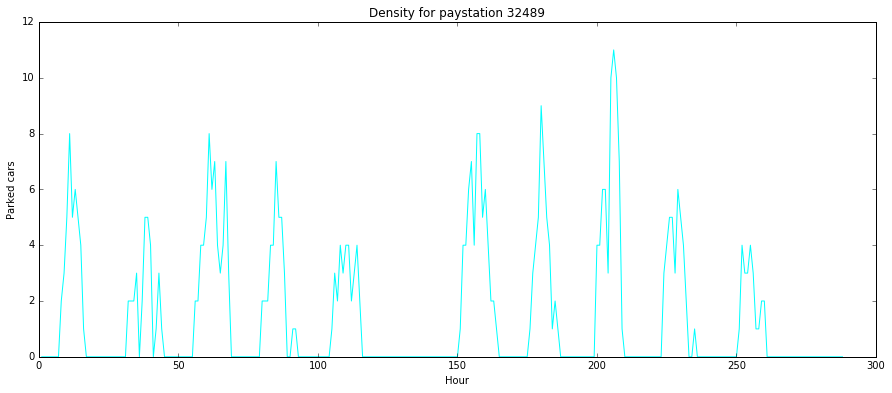

Paystation 32489 popularity = 2593


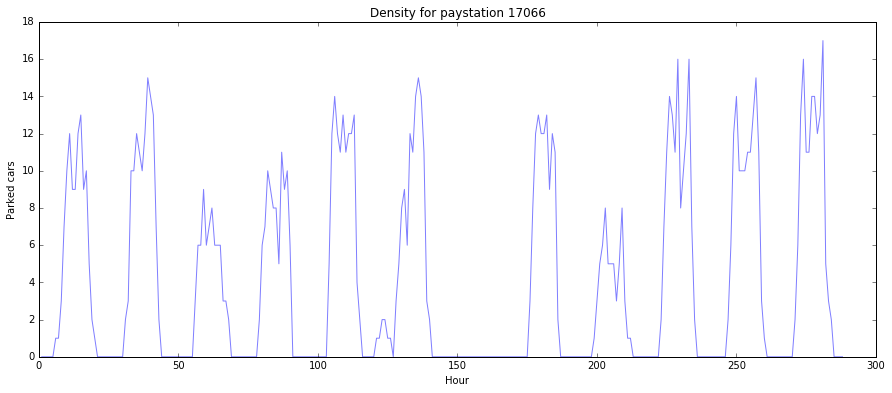

Paystation 17066 popularity = 27985


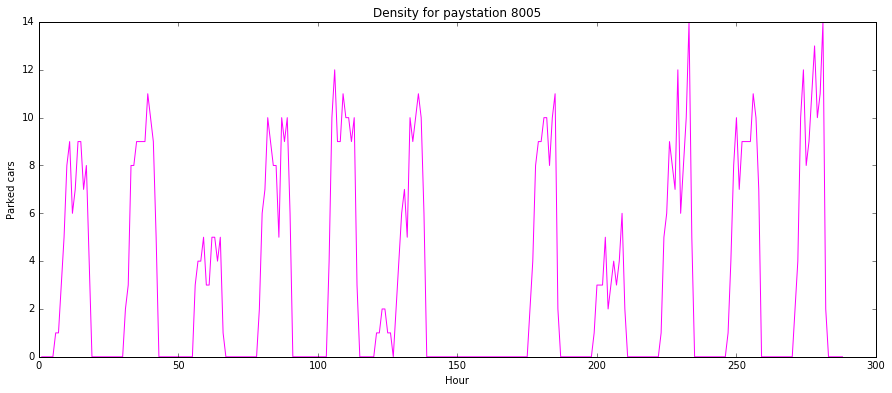

Paystation 8005 popularity = 20483


In [164]:
for i, key in enumerate(elm_keys.keys()):
    data = elm_keys[key]
    data = data[0:12]
    plot_paystation(data, key, i)
    print 'Paystation %s popularity = %d' % (key, np.sum(elm_keys[key]))



## Simple Predictive Model

In [202]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot


In [203]:
f = '../datastore/paystations/32489_59_days_nofree.d' 
key = 32489
data = pickle.load(open(f, 'rb'))
mask = np.all(np.isnan(data), axis=1)
print 'Removed %d free parking days' % sum(mask)

data = data[~mask]



Removed 11 free parking days


In [204]:
ts = data.flatten() # make timeseries
sm.stats.durbin_watson(ts)

0.30248654191233015

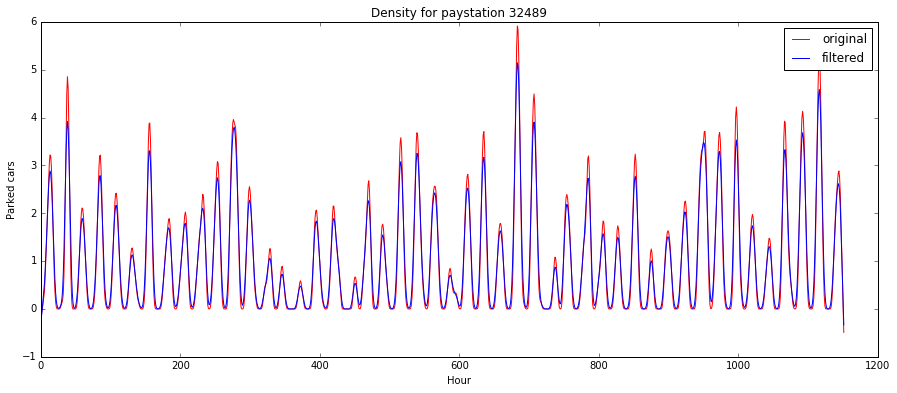

In [230]:
from statsmodels.nonparametric.smoothers_lowess import lowess

step = 0.01  # filter order

hrs = np.arange(len(ts))
filtered = lowess(ts, hrs, is_sorted=True, frac=step, it=0)
plt.plot(hrs, ts, 'r', label="original")
plt.plot(filtered[:,0], filtered[:,1], 'b', label="filtered")
plt.legend()
plt.ylabel('Parked cars')
plt.xlabel('Hour')
plt.title('Density for paystation %s' % key)
plt.show()

#set ts to be the filtered version
ts = filtered[:,1]

The value of Durbin-Watson statistic is close to 2 if the errors are uncorrelated. If small, it means that there is a strong evidence that the variable open has high autocorrelation.

### Show Autocorrelation (and partial)

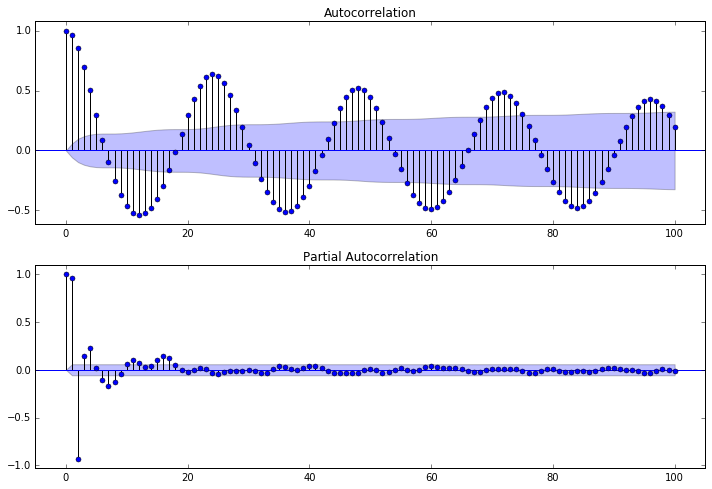

In [214]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags = 100, ax=ax2)


### Try some ARMA(2,0) for prediction

In [224]:
arma_mod20 = sm.tsa.ARMA(ts, (2,0)).fit()

In [225]:
print arma_mod20.params
print arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic

[ 0.98438088  1.89400689 -0.96626177]
-2492.03650211 -2471.83948274 -2484.41312679


In [226]:
sm.stats.durbin_watson(arma_mod20.resid)

0.487211959888871

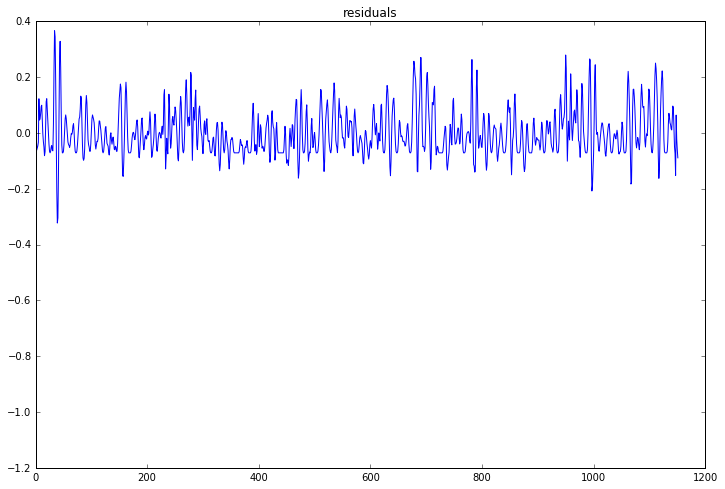

In [227]:
clr = np.linspace(0, 1, 5)
fig = plt.figure(figsize=(12,8))
plt.plot(arma_mod20.resid, 'b')
plt.title('residuals')


#### Residuals
Calculate the residuals, tests the null hypothesis that the residuals come from a normal distribution, and construct a qq-plot

In [228]:
resid20 = arma_mod20.resid
print stats.normaltest(resid20)


NormaltestResult(statistic=514.09297940018564, pvalue=2.3234211085173017e-112)


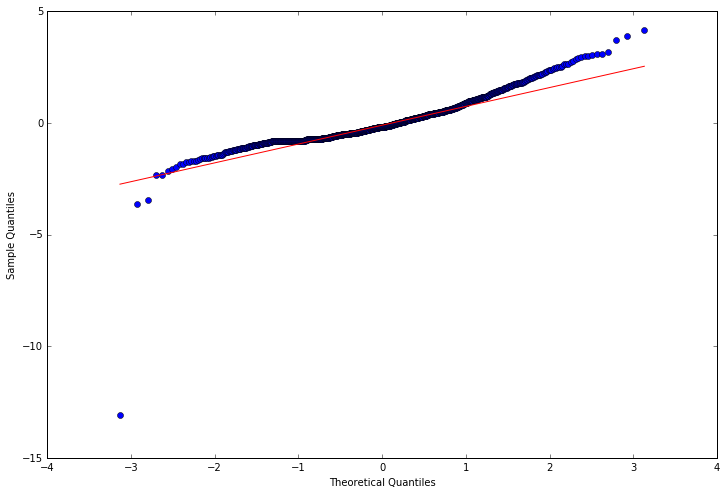

In [229]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid20, line='q', ax=ax, fit=True)

### Autocorrelation of ARMA(2,0)

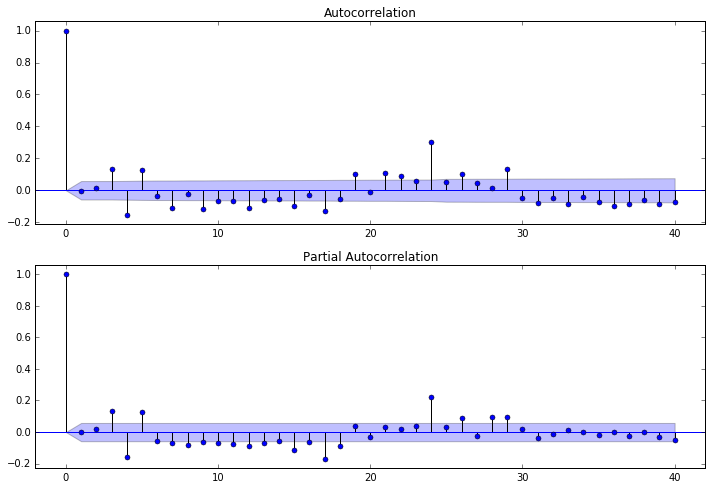

In [197]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid20, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid20, lags=40, ax=ax2)

 calculate the lag, autocorrelation (AC), Q statistic and Prob>Q. Want low Prob(>Q)

In [185]:
r,q,p = sm.tsa.acf(resid20, qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print table.set_index('lag')


           AC           Q      Prob(>Q)
lag                                    
1   -0.002115    0.005168  9.426914e-01
2    0.017090    0.342784  8.424912e-01
3    0.136399   21.868751  6.946415e-05
4   -0.155382   49.827653  3.922782e-10
5    0.124464   67.782667  2.963150e-13
6   -0.035640   69.256179  5.809100e-13
7   -0.110250   83.368985  2.826208e-15
8   -0.023815   84.028075  7.532327e-15
9   -0.115257   99.478769  2.005746e-17
10  -0.065584  104.485919  6.869897e-18
11  -0.068807  110.002059  1.830224e-18
12  -0.109955  124.100829  9.380645e-21
13  -0.058684  128.120405  4.946958e-21
14  -0.057358  131.963729  2.782028e-21
15  -0.098657  143.344140  5.029246e-23
16  -0.031590  144.511985  9.394438e-23
17  -0.129059  164.021311  4.277008e-26
18  -0.052959  167.309292  3.066999e-26
19   0.104100  180.024708  3.059316e-28
20  -0.008135  180.102426  9.269348e-28
21   0.108088  193.835012  5.888761e-30
22   0.087784  202.900904  3.075861e-31
23   0.056124  206.609994  1.794697e-31
